# **Test A/B**

En esta investigación se cuenta con los resultados de las pruebas A/B elaboradas para probar cambios en la conversión de una tienda en línea. La descripción técnica proporcionada es la siguiente:


    - Nombre de la prueba: `recommender_system_test`
    - Grupos: А (control), B (nuevo embudo de pago)
    - Launch date: 2020-12-07
    - Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
    - Fecha de finalización: 2021-01-01
    - Audiencia: 15% de los nuevos usuarios de la región de la UE
    - Número previsto de participantes de la prueba: 6 000


    - Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado


    - Resultado esperado: dentro de los 14 días posteriores a la inscripción,
    los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`),instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
    

# Tabla de contenidos<a id='1'></a>

 1. [Tabla de contenidos](#1)
 2. [Objetivo](#2)
 3. [Preprocesamiento de datos](#3)
 4. [Análisis exploratorio de datos](#4)
 5. [Evaluación de los resultados de la prueba A/B](#5)
 6. [Conclusiones](#6)


# Objetivo <a id='2'></a>

Este análisis tiene dos objetivos:
    

*  El primero, conocer los resultados sobre si hubo o no, aumento de conversión en las pruebas, recordando el resultado esperado:
    * dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en cada etapa del embudo product_page → product_cart → purchase, habrá al menos un 10% de aumento.

* y el segundo, decidir si es necesario continuar con la prueba o, por el contrario, detenerla si se encuentra que los datos son ya concluyentes sobre el comportamiento de los grupos.
    * Tomar en cuenta que el número previsto de participantes de la prueba es de 6,000.



# Preprocesamiento de datos <a id='3'></a>

## Carga de librerías y datos

In [1]:
#Cargaremos las librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import datetime as dt
import scipy.stats as stats
from scipy import stats as st
import math as mth
import plotly.express as px


In [2]:
#Cargaremos los datos
try:
    calendar     = pd.read_csv('/content/ab_project_marketing_events_us.csv')
    events       = pd.read_csv('/content/final_ab_events_upd_us.csv')
    new_users    = pd.read_csv('/content/final_ab_new_users_upd_us.csv')
    participants = pd.read_csv('/content/final_ab_participants_upd_us.csv')
except:
    calendar     = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
    events       = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
    new_users    = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
    participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')



## Primer acercamiento a los datos

### Calendar

Tabla con el calendario de eventos de marketing para el 2020.

Estructura de calendar `ab_project_marketing_events_us.csv`:

- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

In [3]:
calendar

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Se observa que, la promoción #10 CIS New Year Gift Lottery aplicada del 30 de diciembre 2020 al 07 de enero 2021 cae en el periodo de observación de los 14 días posteriores a la inscripción de los nuevos usuarios inscritos entre el 7 y el 21 de diciembre.

In [4]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Se tienen 14 observaciones con 4 características. No hay nulos, ni duplicados.

### Events

Dataset con todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y 1 de enero de 2021.

Estructura de events `final_ab_events_upd_us.csv`:
- `user_id` : identificador del usuario
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)


In [5]:
print(events)
print(events.info())
print(events.duplicated().sum())
events['event_name'].unique()

                 user_id             event_dt event_name  details
0       E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1       7B6452F081F49504   2020-12-07 9:22:53   purchase     9.99
2       9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3       96F27A054B191457   2020-12-07 4:02:40   purchase     4.99
4       1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99
...                  ...                  ...        ...      ...
423756  245E85F65C358E08  2020-12-30 19:35:55      login      NaN
423757  9385A108F5A0A7A7  2020-12-30 10:54:15      login      NaN
423758  DB650B7559AC6EAC  2020-12-30 10:59:09      login      NaN
423759  F80C9BDDEA02E53C   2020-12-30 9:53:39      login      NaN
423760  7AEC61159B672CC5  2020-12-30 11:36:13      login      NaN

[423761 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      ------------

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Tenemos 423,761 observaciones y 4 características.

`event_dt` es tipo object y tiene formato YYYY-MM-DD HH-mm-ss.

No hay nulos en `user_id`, `event_dt`, y `event_name`, pero si los hay en `details` en un 85.7% de los datos de esa columna.

No hay duplicados.

In [6]:
#Ajuste en el nombre de los eventos para que puedan llevar secuencia
events = events.replace({'login':'(1)login', 'product_page':'(2)product_page', 'product_cart':'(3)product_cart', 'purchase':'(4)purchase'})
events['event_name'].unique()

array(['(4)purchase', '(3)product_cart', '(2)product_page', '(1)login'],
      dtype=object)

### New users

Todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020

Estructura `final_ab_new_users_upd_us.csv`:
- `user_id` : identificador del usuario
- `first_date`: fecha de inscripción
- `region` : región
- `device`: dispositivo utilizado para la inscripción

In [7]:
print(new_users)
print(new_users.info())
new_users.duplicated().sum()

                user_id  first_date     region   device
0      D72A72121175D8BE  2020-12-07         EU       PC
1      F1C668619DFE6E65  2020-12-07  N.America  Android
2      2E1BF1D4C37EA01F  2020-12-07         EU       PC
3      50734A22C0C63768  2020-12-07         EU   iPhone
4      E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone
...                 ...         ...        ...      ...
58698  1DB53B933257165D  2020-12-20         EU  Android
58699  538643EB4527ED03  2020-12-20         EU      Mac
58700  7ADEE837D5D8CBBD  2020-12-20         EU       PC
58701  1C7D23927835213F  2020-12-20         EU   iPhone
58702  8F04273BB2860229  2020-12-20         EU  Android

[58703 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  o

0

Tenemos 50,703 observaciones y 4 características.

`first_date` es tipo object y tiene formato YYYY-MM-DD.

No hay nulos, ni hay duplicados.

### Participants

Tabla con los datos de los participantes de la prueba

Estructura `final_ab_participants_upd_us.csv`:
- `user_id` : identificador del usuario
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

In [8]:
print(participants)
print(participants.info())
participants.duplicated().sum()

                user_id group                  ab_test
0      D1ABA3E2887B6A73     A  recommender_system_test
1      A7A3664BD6242119     A  recommender_system_test
2      DABC14FDDFADD29E     A  recommender_system_test
3      04988C5DF189632E     A  recommender_system_test
4      4FF2998A348C484F     A  recommender_system_test
...                 ...   ...                      ...
14520  1D302F8688B91781     B        interface_eu_test
14521  3DE51B726983B657     A        interface_eu_test
14522  F501F79D332BE86C     A        interface_eu_test
14523  63FBE257B05F2245     A        interface_eu_test
14524  79F9ABFB029CF724     B        interface_eu_test

[14525 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
mem

0

Tenemos 14,525 observaciones y 3 características.

No hay nulos, ni hay duplicados.

In [9]:
#Revisemos un poco más
participants.groupby('ab_test')['group'].value_counts()

ab_test                  group
interface_eu_test        A        5467
                         B        5383
recommender_system_test  A        2747
                         B         928
Name: group, dtype: int64

Se detecta que tenemos en este dataset **dos pruebas**:
* interface_eu_test
* recommender_system_test

Se nos ha pedido trabajar con los datos de ésta última por lo que se procede a separar los participantes.

In [10]:
#Generar una tabla con únicamente los participantes de la prueba "Recommender System Test"
rst = participants[participants['ab_test']=='recommender_system_test']
rst

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
3670,053FB26D6D49EDDC,A,recommender_system_test
3671,9D263B8EF15CF188,B,recommender_system_test
3672,F2FBBA33F37DEC46,A,recommender_system_test
3673,29C92313A98B1176,B,recommender_system_test


Nos quedamos entonces con 3,675 participantes para la prueba `recommender_system_test` para la cual, cabe recordar, se habían previsto 6,000 participantes.

In [11]:
#Retomemos a los participantes de interface_eu_test:
iet = participants[participants['ab_test']=='interface_eu_test']
iet

,user_id,group,ab_test
3675,D4E530F6595A05A3,A,interface_eu_test
3676,6BCB0F33D3BAB8C2,A,interface_eu_test
3677,FB6F6BC119E1DBD5,B,interface_eu_test
3678,2D2E7AA539CF348F,B,interface_eu_test
3679,4BA448BCE1343C6F,A,interface_eu_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


In [12]:
#Revisemos que los participantes de recommender_system_test no hayan particapado
#también en interface_eu_test porque esto generaría un sesgo en su comportamiento.
filtro_tests = iet['user_id'].isin(rst['user_id'])
#Veamos quiénes y cuántos son (conservemos las columnas en lugar de que me dé solo un Series)
filtro_tests = iet.loc[filtro_tests]
filtro_tests

,user_id,group,ab_test
3677,FB6F6BC119E1DBD5,B,interface_eu_test
3688,055A4CD17A483B8E,A,interface_eu_test
3695,7060BB1CBE3BAACC,B,interface_eu_test
3711,8A26EBC1BA92524B,B,interface_eu_test
3730,A791C2D62B213C96,B,interface_eu_test
...,...,...,...
14433,7DF21AEB1AA231F9,B,interface_eu_test
14445,EA6EA431FF84563B,B,interface_eu_test
14470,70BF82527E6ED9C3,A,interface_eu_test
14487,EF2E4FAF26951358,A,interface_eu_test


In [13]:
#Retiremos a esos usuarios del df rst:
rst = rst[~rst['user_id'].isin(filtro_tests['user_id'])]
rst = rst.reset_index(drop=True) #si le dejo sólo el reset_index() me lo deja como columna...
rst

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,4FF2998A348C484F,A,recommender_system_test
3,7473E0943673C09E,A,recommender_system_test
4,C46FE336D240A054,A,recommender_system_test
...,...,...,...
2783,053FB26D6D49EDDC,A,recommender_system_test
2784,9D263B8EF15CF188,B,recommender_system_test
2785,F2FBBA33F37DEC46,A,recommender_system_test
2786,29C92313A98B1176,B,recommender_system_test


De los 3,675 que teníamos en rst, ahora conservamos 2,788 usuarios, ya con la seguridad de que tampoco particiaparon en la otra prueba.

In [14]:
#Revisemos la participación en los grupos A y B
#Busquemos que un usuario no participe en los dos grupos

#Obtener los participantes del grupo A
rst_A = rst[rst['group']== 'A']
print('Tenemos', len(rst_A), 'en el grupo A, y')
#Obtener los participantes del grupo B
rst_B = rst[rst['group']== 'B']
print('tenemos', len(rst_B), 'en el grupo B')

Tenemos 2082 en el grupo A, y
tenemos 706 en el grupo B


In [15]:
#Revisar que repetidos en los grupos:
filtro_groups = rst_A['user_id'].isin(rst_B['user_id'])
filtro_groups.value_counts()

False    2082
Name: user_id, dtype: int64

Hemos verificado que no tenemos usuarios que hayan realidado la prueba en los dos grupos, A y B.

# Análisis exploratorio de datos<a id='4'></a>

Vamos a revisar si, dentro de los 14 días posteriores a la inscripción, los usuarios mostraron una mejor conversión en vistas de `product_page`,`product_card`y `purchase`, con al menos un 10% de aumento.


Para ello, fusionaremos los datasets, quitaremos las columnas innecesarias, convertiremos las columnas al formato adecuado y haremos el análisis del **embudo con secuencia de eventos**  sin olvidar considerar nunique en el usuario y no la suma de los eventos ya que un usuario puede realizar varias veces el mismo evento.


### Fusionado de tablas

In [16]:
#Agregaremos a rst (que tiene participants solo de la prueba deseada)
#la información que ofrece la tabla new_users
rst2 = rst.merge(new_users, on='user_id')
#y quitaremos la columna que indica la prueba (ya no es necesaria)
rst2 = rst2.drop(columns='ab_test')
rst2

,user_id,group,first_date,region,device
0,D1ABA3E2887B6A73,A,2020-12-07,EU,PC
1,A7A3664BD6242119,A,2020-12-20,EU,iPhone
2,4FF2998A348C484F,A,2020-12-20,EU,Mac
3,7473E0943673C09E,A,2020-12-16,EU,iPhone
4,C46FE336D240A054,A,2020-12-17,EU,iPhone
...,...,...,...,...,...
2783,053FB26D6D49EDDC,A,2020-12-10,N.America,Android
2784,9D263B8EF15CF188,B,2020-12-16,N.America,Mac
2785,F2FBBA33F37DEC46,A,2020-12-18,APAC,Mac
2786,29C92313A98B1176,B,2020-12-07,APAC,Android


In [17]:
#Agregaremos la información de rst2 a la tabla events por lo tanto,
#nos quedaremos con una tabla más reducida de events ya que no todos los
#eventos pertenecía a usuarios participantes de la prueba
events2 = events.merge(rst2, on='user_id')
#Veamos cuantas filas nos quedan
events2.shape[0]

18194

### Filtrado de eventos en los 14 días posteriores a la inscripción

In [18]:
#Tomaremos los valores de las columnas de fecha y los convertiremos al formato correcto
events2['first_date']= pd.to_datetime(events2['first_date'], format="%Y-%m-%d")
events2['event_dt']= pd.to_datetime(events2['event_dt'], format="%Y-%m-%d")

In [19]:
#Generaremos una nueva columna donde tendremos la cantidad de días
#posteriores a la inscripción de cuando se realizó el evento

events2['days_after'] = (events2['event_dt'].dt.date - events2['first_date'].dt.date).dt.days
events2['days_after'].unique() #unique solo para supervisar que la operación fue adecuada
#y ver si tenemos eventos sucedidos fuera de los 14 días posteriores a la suscripción

array([ 0,  2,  1,  4,  5,  9,  8,  3, 10, 13, 15,  6, 12, 22, 11,  7, 16,
       20, 17, 21, 19, 14, 18, 23])

In [20]:
#Y ordenaremos sus columnas para facilitar el trabajo
events2 = events2[['user_id', 'group', 'first_date', 'event_dt', 'days_after', 'event_name', 'details',
       'region', 'device']]

In [21]:
#Eliminar las observaciones que sucedieron más allá del marco de los 14 días posteriores a la suscripción
events3 = events2[events2['days_after']<=14]
#verificar que sí nos vamos a quedar con rango de días adecuado
print(events3['days_after'].unique())
#Veamos cuantas filas nos quedaron
events3.shape[0]

[ 0  2  1  4  5  9  8  3 10 13  6 12 11  7 14]


17786

### Separación de los dos grupos: A y B

In [22]:
#Eventos en el grupo A
events3_A = events3[events3['group']=='A']
events3_A.shape[0]

13979

In [23]:
#Usuarios en el grupo A
events3_A['user_id'].nunique()

2082

In [24]:
#Eventos en el grupo B
events3_B = events3[events3['group']=='B']
events3_B.shape[0]

3807

In [25]:
#Usuarios en el grupo B
events3_B['user_id'].nunique()

706

In [26]:
events3_A

,user_id,group,first_date,event_dt,days_after,event_name,details,region,device
0,831887FE7F2D6CBA,A,2020-12-07,2020-12-07 06:50:29,0,(4)purchase,4.99,EU,Android
1,831887FE7F2D6CBA,A,2020-12-07,2020-12-09 02:19:17,2,(4)purchase,99.99,EU,Android
2,831887FE7F2D6CBA,A,2020-12-07,2020-12-07 06:50:30,0,(3)product_cart,NaN,EU,Android
3,831887FE7F2D6CBA,A,2020-12-07,2020-12-08 10:52:27,1,(3)product_cart,NaN,EU,Android
4,831887FE7F2D6CBA,A,2020-12-07,2020-12-09 02:19:17,2,(3)product_cart,NaN,EU,Android
...,...,...,...,...,...,...,...,...,...
18185,64597B30278462F5,A,2020-12-21,2020-12-23 14:14:46,2,(1)login,NaN,EU,Android
18186,1484BBF124DB1B18,A,2020-12-21,2020-12-21 17:51:44,0,(1)login,NaN,EU,PC
18187,1484BBF124DB1B18,A,2020-12-21,2020-12-22 16:02:18,1,(1)login,NaN,EU,PC
18188,1484BBF124DB1B18,A,2020-12-21,2020-12-27 10:53:34,6,(1)login,NaN,EU,PC


#### Embudo de secuencia de eventos para A

In [27]:
#Ahora sí, buscaremos la transición de una evento a otro en el grupo A.

#Primero, hagamos una pivot table para encontrar para cada usuario
#la hora exacta en que se dio un paso en particular por primera vez

users = events3_A.pivot_table(
    index='user_id',
    columns='event_name',
    values='event_dt',
    aggfunc='min'
    )
users.head()


event_name,(1)login,(2)product_page,(3)product_cart,(4)purchase
user_id,,,,
0010A1C096941592,2020-12-17 21:07:27,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27
003DF44D7589BBD4,2020-12-17 06:17:49,2020-12-17 06:17:49,2020-12-17 06:17:49,NaT
00505E15A9D81546,2020-12-14 17:28:32,NaT,NaT,NaT
006E3E4E232CE760,2020-12-17 16:40:41,2020-12-17 16:40:42,NaT,NaT
00A52DCF85F1BE03,2020-12-20 06:41:11,NaT,NaT,NaT


In [28]:
#Total de usuarios en login
n_login_A = users['(1)login'].count()
n_login_A

2082

In [29]:
#Para saber cuantos usuarios pasaron de una etapa a otra, encontremos
#el número de los que sí tienen el evento product_page

n_product_page_A = users[~users['(2)product_page'].isna()].shape[0]
n_product_page_A

1360

In [30]:
#Busquemos el número de usuarios que pasaron de product_page a product_cart
#agregando la comparación de que la hora del nuevo evento sea mayor que la del evento anterior
n_product_cart_A = users[~users['(2)product_page'].isna() &
                       (users['(3)product_cart'] > users['(2)product_page'])].shape[0]
n_product_cart_A

126

In [31]:
#Veamos la siguiente etapa
n_purchase_A = users[~users['(2)product_page'].isna() &
                   (users['(3)product_cart'] > users['(2)product_page']) &
                   (users['(4)purchase'] > users['(3)product_cart'])
                   ].shape[0]
n_purchase_A

0

In [32]:
#Visualicemos esta inforamción en un embudo
stages = ['(1)login','(2)product_page', '(3)product_cart', '(4)purchase']
df_a = pd.DataFrame(dict(count=[n_login_A, n_product_page_A, n_product_cart_A, n_purchase_A], stage=stages))
df_a['Group'] = 'A'
df_a
fig = px.funnel(df_a, x='count', y='stage', color='Group')
fig.show()

#### Embudo de secuencia de eventos para B

In [33]:
#Ahora, buscaremos la transición de una evento a otro en el grupo B.

#Primero, hagamos una pivot table para encontrar para cada usuario
#la hora exacta en que se dio un paso en particular por primera vez

users = events3_B.pivot_table(
    index='user_id',
    columns='event_name',
    values='event_dt',
    aggfunc='min')
users.head()


event_name,(1)login,(2)product_page,(3)product_cart,(4)purchase
user_id,,,,
005E096DBD379BCF,2020-12-21 07:20:39,NaT,NaT,2020-12-21 07:20:39
015D1E3BB893349D,2020-12-16 21:14:05,2020-12-16 21:14:06,NaT,NaT
015FF3EC72C1F4F6,2020-12-20 08:29:30,2020-12-20 08:29:31,NaT,NaT
01B0B891CA513468,2020-12-16 22:35:11,2020-12-16 22:35:11,2020-12-16 22:35:11,NaT
01C17F099908DA14,2020-12-09 22:40:45,NaT,NaT,NaT


In [34]:
#Total de usuarios en login
n_login_B = users['(1)login'].count()
n_login_B

705

In [35]:
#Para saber cuantos usuarios pasaron de una etapa a otra, encontremos
#el número de los que sí tienen el evento product_page

n_product_page_B = users[~users['(2)product_page'].isna()].shape[0]
n_product_page_B

397

In [36]:
#Busquemos el número de usuarios que pasaron de product_page a product_cart
#agregando la comparación de que la hora del nuevo evento sea mayor que la del evento anterior
n_product_cart_B = users[~users['(2)product_page'].isna() &
                       (users['(3)product_cart'] > users['(2)product_page'])].shape[0]
n_product_cart_B

38

In [37]:
#Veamos la siguiente etapa
n_purchase_B = users[~users['(2)product_page'].isna() &
                   (users['(3)product_cart'] > users['(2)product_page']) &
                   (users['(4)purchase'] > users['(3)product_cart'])
                   ].shape[0]
n_purchase_B

1

In [38]:
#Visualicemos esta inforamción en un embudo
stages = ['(1)login', '(2)product_page', '(3)product_cart', '(4)purchase']
df_b = pd.DataFrame(dict(count=[n_login_B, n_product_page_B, n_product_cart_B, n_purchase_B], stage=stages))
df_b['Group'] = 'B'

fig = px.funnel(df_b, x='count', y='stage', color='Group')
fig.show()

In [39]:
#Presentemos los embudos de los dos grupos en un df
df_funnel = pd.concat([df_a, df_b], axis=0)
df_funnel

,count,stage,Group
0,2082,(1)login,A
1,1360,(2)product_page,A
2,126,(3)product_cart,A
3,0,(4)purchase,A
0,705,(1)login,B
1,397,(2)product_page,B
2,38,(3)product_cart,B
3,1,(4)purchase,B


In [40]:
fig = px.funnel(df_funnel, x='count', y='stage', color='Group')
fig.show()

#### Porcentajes de conversión por etapa por grupo

In [41]:
# Calcular los porcentajes de conversión dentro de cada grupo
df_funnel['percentage'] = (df_funnel['count'].pct_change().fillna(0)) * 100
df_funnel['percentage'] = (100+df_funnel['percentage']).round(2)
#Reemplazar el infitito que sale en la primera fila del grupo B
df_funnel['percentage'] = df_funnel['percentage'].replace([float('inf')], 100)
df_funnel

,count,stage,Group,percentage
0,2082,(1)login,A,100.00
1,1360,(2)product_page,A,65.32
2,126,(3)product_cart,A,9.26
3,0,(4)purchase,A,0.00
0,705,(1)login,B,100.00
1,397,(2)product_page,B,56.31
2,38,(3)product_cart,B,9.57
3,1,(4)purchase,B,2.63


In [42]:
#Embudo de los porcentajes de conversión de los dos grupos
fig = px.funnel(df_funnel, x='percentage', y='stage', color='Group')
fig.show()

#### Distribución de los eventos

In [43]:
#Preparemos el grupo A
a = events3_A.groupby(['days_after','event_name'])['event_name'].count().to_frame()
#y renombramos la columna
a = a.rename(columns={'event_name':'count'})
a = a.reset_index()
a.head(10)

,days_after,event_name,count
0,0,(1)login,2073
1,0,(2)product_page,1357
2,0,(3)product_cart,630
3,0,(4)purchase,650
4,1,(1)login,1036
5,1,(2)product_page,672
6,1,(3)product_cart,317
7,1,(4)purchase,309
8,2,(1)login,708
9,2,(2)product_page,448


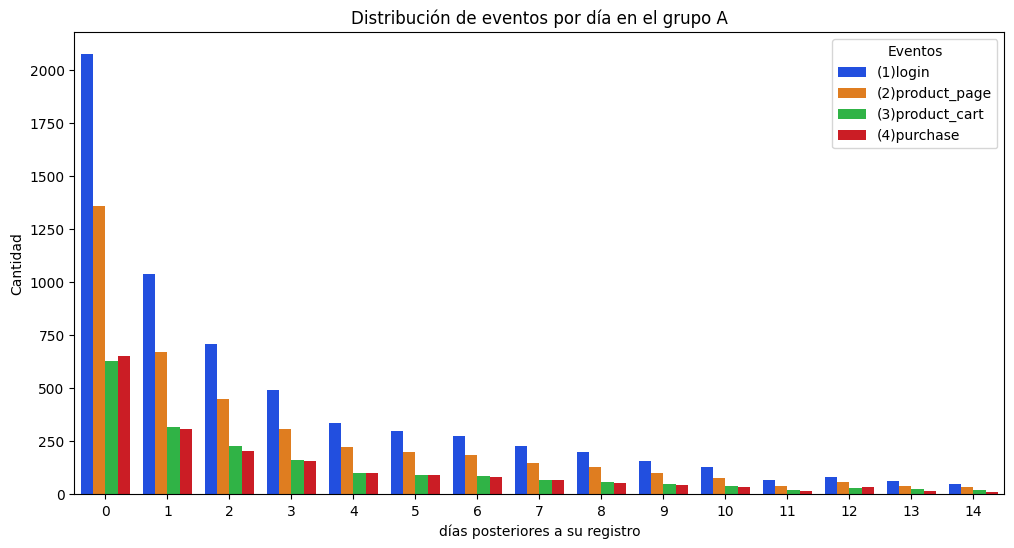

In [44]:
# Graficamos en barras para visualizar la distribución
plt.figure(figsize=(12, 6))
sns.barplot(data=a, x='days_after', y='count', hue='event_name', palette='bright')

plt.title('Distribución de eventos por día en el grupo A')
plt.xlabel('días posteriores a su registro')
plt.ylabel('Cantidad')
plt.legend(title='Eventos')
plt.show()

In [45]:
#Tenemos la cantidad de eventos en cada uno de los 14 días del grupo A
#Obtengamos un promedio de esas cantidades
a_means = a.groupby('event_name')['count'].mean().round(2)
a_means = a_means.reset_index()
a_means

,event_name,count
0,(1)login,412.60
1,(2)product_page,267.80
2,(3)product_cart,127.07
3,(4)purchase,124.47


In [46]:
#Gráfico de embudo de esas medias del grupo A
fig = px.funnel(a_means, x='count', y='event_name')
fig.show()

In [47]:
#Preparemos el grupo B
b = events3_B.groupby(['days_after','event_name'])['event_name'].count().to_frame()
#y renombramos la columna
b = b.rename(columns={'event_name':'count'})
b = b.reset_index()
b.head(10)

,days_after,event_name,count
0,0,(1)login,694
1,0,(2)product_page,389
2,0,(3)product_cart,192
3,0,(4)purchase,195
4,1,(1)login,283
5,1,(2)product_page,147
6,1,(3)product_cart,80
7,1,(4)purchase,67
8,2,(1)login,186
9,2,(2)product_page,98


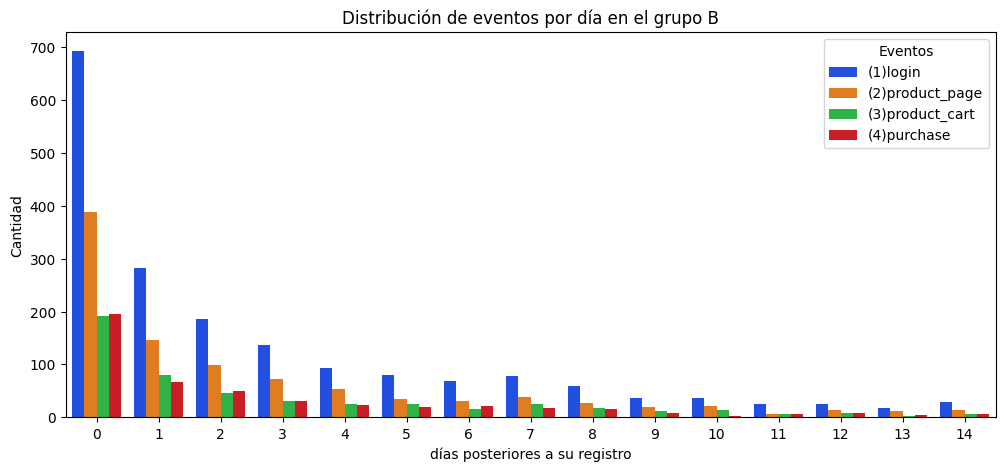

In [48]:
# Graficamos en barras para visualizar la distribución
plt.figure(figsize=(12, 5))
sns.barplot(data=b, x='days_after', y='count', hue='event_name', palette='bright')

plt.title('Distribución de eventos por día en el grupo B')
plt.xlabel('días posteriores a su registro')
plt.ylabel('Cantidad')
plt.legend(title='Eventos')
plt.show()

In [49]:
#Tenemos la cantidad de eventos en cada uno de los 14 días del grupo B
#Obtengamos un promedio de esas cantidades
b_means = b.groupby('event_name')['count'].mean().round(2)
b_means = b_means.reset_index()
b_means

,event_name,count
0,(1)login,123.13
1,(2)product_page,65.13
2,(3)product_cart,33.80
3,(4)purchase,31.73


In [50]:
#Gráfico de embudo de esas medias del grupo B
fig = px.funnel(b_means, x='count', y='event_name')
fig.show()

In [51]:
#Unamos las medias de los dos grupos en un df
df_dist_funnel = pd.concat([a_means, b_means], axis=0)
df_dist_funnel['Group'] = ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B']
df_dist_funnel

,event_name,count,Group
0,(1)login,412.60,A
1,(2)product_page,267.80,A
2,(3)product_cart,127.07,A
3,(4)purchase,124.47,A
0,(1)login,123.13,B
1,(2)product_page,65.13,B
2,(3)product_cart,33.80,B
3,(4)purchase,31.73,B


In [52]:
#Embudo de las medias de todos los eventos (que fueron contados por día) de cada grupo
fig = px.funnel(df_dist_funnel, x='count', y='event_name', color='Group')
fig.show()

# Evaluación de los resultados de la prueba A/B<a id='5'></a>

### Significancia estadística de las diferencias en la tasa de conversión

In [53]:
events3_A

,user_id,group,first_date,event_dt,days_after,event_name,details,region,device
0,831887FE7F2D6CBA,A,2020-12-07,2020-12-07 06:50:29,0,(4)purchase,4.99,EU,Android
1,831887FE7F2D6CBA,A,2020-12-07,2020-12-09 02:19:17,2,(4)purchase,99.99,EU,Android
2,831887FE7F2D6CBA,A,2020-12-07,2020-12-07 06:50:30,0,(3)product_cart,NaN,EU,Android
3,831887FE7F2D6CBA,A,2020-12-07,2020-12-08 10:52:27,1,(3)product_cart,NaN,EU,Android
4,831887FE7F2D6CBA,A,2020-12-07,2020-12-09 02:19:17,2,(3)product_cart,NaN,EU,Android
...,...,...,...,...,...,...,...,...,...
18185,64597B30278462F5,A,2020-12-21,2020-12-23 14:14:46,2,(1)login,NaN,EU,Android
18186,1484BBF124DB1B18,A,2020-12-21,2020-12-21 17:51:44,0,(1)login,NaN,EU,PC
18187,1484BBF124DB1B18,A,2020-12-21,2020-12-22 16:02:18,1,(1)login,NaN,EU,PC
18188,1484BBF124DB1B18,A,2020-12-21,2020-12-27 10:53:34,6,(1)login,NaN,EU,PC


In [54]:
#Imputemos los nulos con cero para poder trabajarlos
events3_A = events3_A.fillna(0)
events3_B = events3_B.fillna(0)

#Tengamos la suma de eventos que tiene cada usuario de cada grupo de la prueba
A = events3_A.groupby('user_id', as_index=False).agg({'event_name' : pd.Series.nunique})
sampleA = A['event_name']
print(sampleA)
B = events3_B.groupby('user_id', as_index=False).agg({'event_name' : pd.Series.nunique})
sampleB = B['event_name']
sampleB

0       3
1       3
2       1
3       2
4       1
       ..
2077    3
2078    2
2079    3
2080    2
2081    2
Name: event_name, Length: 2082, dtype: int64


0      2
1      2
2      2
3      3
4      1
      ..
701    2
702    2
703    2
704    4
705    2
Name: event_name, Length: 706, dtype: int64

In [55]:
A

,user_id,event_name
0,0010A1C096941592,3
1,003DF44D7589BBD4,3
2,00505E15A9D81546,1
3,006E3E4E232CE760,2
4,00A52DCF85F1BE03,1
...,...,...
2077,FF4456FBA59116E3,3
2078,FF5A1CD38F5DD996,2
2079,FF5B24BCE4387F86,3
2080,FF825C1D791989B5,2


In [56]:
B

,user_id,event_name
0,005E096DBD379BCF,2
1,015D1E3BB893349D,2
2,015FF3EC72C1F4F6,2
3,01B0B891CA513468,3
4,01C17F099908DA14,1
...,...,...
701,FD43AFAEA83A6A3F,2
702,FDF5D9D1B047FA31,2
703,FE244437A4224900,2
704,FE76759FE6BF8C68,4


In [57]:
#Imprimir la ganacia relativa de conversión para el grupo B
print("{0:.10f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
#Abrí la cifra a 10 decimales porque quería ver que no fueran puros ceros...

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.0000201067
-0.067


Conclusión: Sí hay diferencia entre los grupos A y B.

Esto porque:

La primera fila de la salida nos da el valor p: 0.000, que es menor que 0.05.

Entonces, se puede rechazar la hipótesis nula ya que hay una diferencia estadísticamente significativa en la conversión entre los grupos.

La pérdida relativa del grupo B es del 6.7% (la segunda fila de la salida).




### Probar la hipótesis de que las proporciones son iguales

#### Suma de eventos

In [58]:

alpha = .05 # nivel de significación

    #Estos éxitos en la conversión son la suma de (1780+158+0=1938) en el grupo A y de (523+50+1=574) en el grupo B
successes = np.array([1938, 574])
    #Estos trials son la cantidad de usuarios en el grupo A y en el grupo B
trials = np.array([2747, 928])

# proporción de éxito en el grupo A:
p1 = successes[0]/trials[0]

# proporción de éxito en el grupo B:
p2 = successes[1]/trials[1]

# proporción de éxito en el dataset unido:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# la diferencia entre las proporciones de los datasets
difference = p1 - p2

In [59]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)

In [60]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

p-value:  8.456748039620265e-07
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones


La decisión que se debe tomar es **continuar** la prueba, al momento sí hay diferncia entre los grupos, pero los grupos de las muestras no estaban equilibrados en su cantidad de participantes.

#### Product_page

In [61]:
alpha = .05 # nivel de significación
    #Exitos en la conversión de product_page(1780) en el grupo A y de (523) en el grupo B
successes = np.array([1780, 523])
    #Estos trials son la cantidad de usuarios en el grupo A y en el grupo B
trials = np.array([2747, 928])
# proporción de éxito en el grupo A:
p1 = successes[0]/trials[0]
# proporción de éxito en el grupo B:
p2 = successes[1]/trials[1]
# proporción de éxito en el dataset unido:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# la diferencia entre las proporciones de los datasets
difference = p1 - p2

In [62]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)

In [63]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-value: ', p_value)
if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

p-value:  4.310980554755872e-06
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones


#### Product_cart

In [64]:
alpha = .05 # nivel de significación
    #Exitos en la conversión de product_cart(158) en el grupo A y de (50) en el grupo B
successes = np.array([158, 50])
    #Estos trials son la cantidad de usuarios en el grupo A y en el grupo B
trials = np.array([2747, 928])
# proporción de éxito en el grupo A:
p1 = successes[0]/trials[0]
# proporción de éxito en el grupo B:
p2 = successes[1]/trials[1]
# proporción de éxito en el dataset unido:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# la diferencia entre las proporciones de los datasets
difference = p1 - p2

In [65]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)

In [66]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-value: ', p_value)
if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

p-value:  0.6783966107957959
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


#### Purchase

In [67]:
alpha = .05 # nivel de significación
    #Exitos en la conversión de purchase(0) en el grupo A y de (1) en el grupo B
successes = np.array([0, 1])
    #Estos trials son la cantidad de usuarios en el grupo A y en el grupo B
trials = np.array([2747, 928])
# proporción de éxito en el grupo A:
p1 = successes[0]/trials[0]
# proporción de éxito en el grupo B:
p2 = successes[1]/trials[1]
# proporción de éxito en el dataset unido:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# la diferencia entre las proporciones de los datasets
difference = p1 - p2

In [68]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)

In [69]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-value: ', p_value)
if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

p-value:  0.0852986021202613
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


# Conclusiones<a id=''></a>

#### Sobre el análisis exploratorio de los datos

* De la tabla participants se tomaron únicamente los correspondientes a la prueba "recommended_system_test" no se tomaron en consideración los correspondientes a la otra prueba que traía el dataset.

Recordemos que con la prueba se buscaba:

*  conocer los resultados sobre si hubo o no, aumento de conversión en las pruebas, recordando el resultado esperado:
    * que dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en cada etapa del embudo product_page → product_cart → purchase, habiendo al menos un 10% de aumento.

Se puede observar que, no hay un aumento significativo en las conversiones por evento entre los dos grupos.


#### Sobre la prueba A/B

* La prueba A/B no tiene el mínimo de 6,000 usuarios que se había contemplado, se tuvo que trabajar con un total de 2,788 (2,082 en el grupo A y 706 en el grupo B).

* Hay una cantidad de usuarios desequilibrada entre los dos grupos (aúnque sí está equilibrada la cantidad de eventos para cada usuario ya que se filtró para un solo evento por primera vez, es decir, no contaron las 3 o cuatro compras del usuario sino solo la primera).

* A partir de la prueba de *significancia estadística de las diferencias en la tasa de conversión* y de la prueba de *hipótesis de las proporciones iguales*, se concluye que: sí hay diferencia entre los grupos A y B.


* La decisión que se debe tomar es **continuar la prueba**, al momento sí hay diferencia entre los grupos, pero los grupos de las muestras no estaban equilibrados en su cantidad de participantes.
